In [31]:
import numpy as np
import pandas as pd
from scipy.sparse import issparse
from pathlib import Path
import scanpy as sc
import geopandas as gpd
from sklearn_ann.kneighbors.annoy import AnnoyTransformer
# to install %pip install -q "scanpy" "sklearn-ann[annoy]"
import matplotlib.pyplot as plt
import scanpy.external as sce
import random


In [32]:
# set global seed
SEED = 1337

np.random.seed(SEED)
random.seed(SEED)

In [33]:
segmentation_path = Path("/Users/janzules/Roselab/Spatial/dietary_project/data/segmented_data/")
adata_file     = segmentation_path / "combined_adata.h5ad"
geneList = segmentation_path / "Gene_lists"
fig_out = Path("/Users/janzules/Roselab/Spatial/dietary_project/figures/cell_segmentation_result_analysis/Improving_clustering/")
ST_sample = sc.read_h5ad(adata_file)

In [34]:
# 1. Print number of cells BEFORE subsetting
print(f"Before subsetting: {ST_sample.n_obs} cells")

# 2. Define the samples you want to keep
# samples_to_keep = ['F07837', 'F07838'] # SKO
samples_to_keep = ['F07833', 'F07834', 'F07835', 'F07836'] # MycCAp
# 3. Perform subsetting
ST_sample = ST_sample[ST_sample.obs['sample_id'].isin(samples_to_keep)].copy()

# 4. Print number of cells AFTER subsetting
print(f"After subsetting: {ST_sample.n_obs} cells")

# 5. Quick sanity check: Which sample_ids are present now?
print("Remaining sample_ids:", ST_sample.obs['sample_id'].unique())

Before subsetting: 1193549 cells
After subsetting: 846263 cells
Remaining sample_ids: ['F07833', 'F07834', 'F07835', 'F07836']
Categories (4, object): ['F07833', 'F07834', 'F07835', 'F07836']


In [35]:
# segmentation_path = Path(
#     "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
#     "dietary_droject/data/cell_segmentation"
# )

# full_data_path = segmentation_path / "concatenated"
# adata_file     = full_data_path / "combined_adata.h5ad"


# # where to dump CSVs of top markers
# hvg_dir = full_data_path / "analysis" / "HVG"
# hvg_dir.mkdir(parents=True, exist_ok=True)

# path to your cell-cycle gene lists
# geneList = (
#     "/mnt/c/Users/jonan/Documents/1Work/RoseLab/Spatial/"
#     "dietary_droject/data/cell_typing_reference_from_pc/Gene_lists"
# )

# Load data
# ST_sample = sc.read_h5ad(adata_file)

In [36]:
# Cleaning
# Identify mitochondrial genes (prefix 'MT-' for human)
ST_sample.var['mito'] = ST_sample.var_names.str.startswith('mt-')

#  Run QC metrics
sc.pp.calculate_qc_metrics(
    ST_sample, 
    qc_vars=['mito'], 
    inplace=True, 
    log1p=False
)

sc.pp.filter_genes(ST_sample, min_cells=20)
sc.pp.filter_cells(ST_sample, min_genes = 100)
ST_sample = ST_sample[
    (ST_sample.obs['total_counts'] >= 150) &
    (ST_sample.obs['pct_counts_mito'] <= 15)
].copy()

In [37]:
# plt.figure(figsize=(6,4))
# plt.hist(ST_sample.obs['total_counts'], bins=100)
# plt.yscale('log')              # log y‐axis to see the tail more clearly
# plt.xlabel('Total UMI counts per cell')
# plt.ylabel('Number of cells')
# plt.title('Histogram of UMI counts')
# plt.tight_layout()
# plt.show()

In [38]:
# import matplotlib.pyplot as plt

# # prepare data
# df = ST_sample.obs[['sample_id','total_counts']]

# # build one violin per sample
# samples = df['sample_id'].cat.categories
# data = [ df.loc[df['sample_id']==s, 'total_counts'] for s in samples ]

# plt.figure(figsize=(8,4))
# plt.violinplot(data, showmedians=True)
# plt.xticks(range(1,len(samples)+1), samples, rotation=90)
# plt.yscale('log')
# plt.ylabel('Total UMI counts')
# plt.title('UMI distribution by sample')
# plt.tight_layout()
# plt.show()


In [39]:
# Saving count data
ST_sample.layers["counts"] = ST_sample.X.copy()

In [40]:
# # normalize + log1p
# sc.pp.normalize_total(ST_sample, target_sum=1e4)
# sc.pp.log1p(ST_sample)

In [41]:
# #Cell-cycle scoring
# with open(f"{geneList}/cc_mouse_cycle_genes.json") as jf:
#     cc = json.load(jf)
# s_genes_mouse   = cc["s_genes"]
# g2m_genes_mouse = cc["g2m_genes"]


# sc.tl.score_genes_cell_cycle(
#     ST_sample,
#     s_genes   = s_genes_mouse,
#     g2m_genes = g2m_genes_mouse,
#     use_raw   = False
# )

In [42]:
# Immune scoring
immune_genes = [
    # T cells
    "Cd3e",   # pan-T cell marker (TCR complex)
    "Cd4",    # CD4+ T helper cells
    "Cd8a",   # CD8+ cytotoxic T cells
    "Foxp3",  # regulatory T cells (Tregs)
    "Pdcd1",  # exhausted T cells (PD-1)
    "Ctla4",  # inhibitory receptor, Tregs, exhausted T cells
    "Ptprc"   # CD45

    # NK cells
    "Ncr1",   # NK cell activating receptor
    "Prf1",   # perforin (cytotoxic granule, NK and CD8 T cells)
    "Gzmb",   # granzyme B (cytotoxic granule, NK and CD8 T cells)
    "Ifng",   # interferon-gamma (produced by NK and T cells)

    # B cells
    "Cd79a",  # B-cell receptor complex
    "Cd19",   # pan-B cell marker
    "Ms4a1",  # CD20 (B-cell marker)

    # Macrophages / Monocytes
    "Adgre1", # F4/80 (macrophage marker)
    "Itgam",  # CD11b (macrophages, monocytes, neutrophils)
    "Csf1r",  # macrophage colony-stimulating factor receptor
    "Mrc1",   # CD206, M2 macrophages (pro-tumor TAMs)

    # Dendritic cells (DCs)
    "Itgax",  # CD11c (dendritic cells)
    "H2-Ab1", # MHC class II (antigen presentation, DCs, macrophages)
    "Cd74",   # invariant chain for MHC II (antigen presentation)

    # MDSC / Neutrophils
    "Ly6g",   # neutrophils, granulocytic-MDSCs
    "S100a8", # neutrophils, MDSCs
    "S100a9", # neutrophils, MDSCs
    "Nos2",   # M1 macrophages, anti-tumor, nitric oxide synthase
    "Arg1",   # M2 macrophages, immunosuppressive MDSCs

    # Mast cells
    "Kit",    # stem cell factor receptor (mast cells)
    "Fcer1a", # high-affinity IgE receptor (mast cells)
    "Cpa3",   # mast cell-specific protease

    # General inflammatory mediators
    "Il1b",   # pro-inflammatory cytokine (macrophages, neutrophils)
    "Tnf"     # tumor necrosis factor alpha (broad immune activation)
]

sc.tl.score_genes(
    ST_sample,
    gene_list=immune_genes,
    score_name="Immune_score"
)

In [ ]:
pten_downstream_genes = [
    # PI3K → AKT → mTOR core cascade
    "Pik3ca",  # PI3K catalytic subunit alpha
    "Pik3cb",  # PI3K catalytic subunit beta
    "Pik3cd",  # PI3K catalytic subunit delta
    "Pik3cg",  # PI3K catalytic subunit gamma
    "Akt1",    # AKT serine/threonine kinase 1
    "Akt2",    # AKT serine/threonine kinase 2
    "Akt3",    # AKT serine/threonine kinase 3
    "Mtor",    # mechanistic target of rapamycin (mTOR)

    # Direct AKT substrates / pathway read-outs
    "Foxo1",   # Forkhead box O1 (transcription factor, inhibited by AKT)
    "Foxo3",   # Forkhead box O3 (transcription factor, inhibited by AKT)
    "Gsk3b",   # Glycogen synthase kinase 3 beta (inhibited by AKT)
    "Bad",     # BCL2-associated agonist of cell death (pro-apoptotic, inhibited by AKT)
    "Mdm2",    # E3 ubiquitin-protein ligase Mdm2 (p53 regulation, activated by AKT)
    "Tsc2",    # Tuberous sclerosis complex 2 (TSC complex, inhibited by AKT)
    "Cdkn1a",  # Cyclin-dependent kinase inhibitor 1A (p21, AKT-regulated)
    "Cdkn1b",  # Cyclin-dependent kinase inhibitor 1B (p27, AKT-regulated)

    # mTORC1 translational targets
    "Rps6kb1", # Ribosomal protein S6 kinase beta-1 (S6K1, downstream of mTORC1)
    "Eif4ebp1",# Eukaryotic translation initiation factor 4E binding protein 1 (4E-BP1)
    "Rps6",    # Ribosomal protein S6 (target of S6K1 phosphorylation)

    # Cell-cycle & growth genes induced downstream
    "Myc",     # MYC proto-oncogene (cell growth, proliferation)
    "Ccnd1",   # Cyclin D1 (G1/S cell cycle transition)
    "Cdk4",    # Cyclin-dependent kinase 4 (partners with Cyclin D)
    "Cdk6",    # Cyclin-dependent kinase 6 (partners with Cyclin D)
    "Vegfa",   # Vascular endothelial growth factor A (angiogenesis, upregulated by mTOR-HIF1A)
    "Hif1a",   # Hypoxia-inducible factor 1-alpha (upregulated downstream of mTOR)

    # Anti-/pro-apoptotic balance
    "Bcl2",    # B-cell lymphoma 2 (anti-apoptotic)
    "Mcl1",    # Myeloid cell leukemia 1 (anti-apoptotic)
    "Bax",     # BCL2 associated X, apoptosis regulator (pro-apoptotic)
    "Bak1"     # BCL2 antagonist/killer 1 (pro-apoptotic)
]


In [43]:

# pten genes from Glaviano et al. 2023
pten_genes = [
    "Pik3ca", "Pik3cb", "Pik3cd", "Pik3cg",
    "Akt1", "Akt2", "Akt3",
    "Mtor"
]

# based on CHI V. DANG* 1999 - mini review of myc genes
myc_growth     = ["Ccna2", "Ccnd1", "Ccne1", "Cdk1", "Cdc25a", "Rcc1", "Odc1", "Tert", "Tk1"]
myc_survival   = ["Cdkn2a", "Trp53", "Bax"]
myc_metabolism = ["Ldha", "Cad", "Dhfr", "Eif2s1", "Eif4e", "Rida"]
myc_cap_genes  = myc_growth + myc_survival + myc_metabolism

# 2) compute module scores on the normalized log1p data
sc.tl.score_genes(
    ST_sample,
    gene_list=pten_genes,
    score_name="PTENSKO_score"
)

sc.tl.score_genes(
    ST_sample,
    gene_list=myc_cap_genes,
    score_name="MycCAP_score"
)

In [44]:
# HVG selection
sc.pp.highly_variable_genes(
    ST_sample,
    n_top_genes=2000, #default 2k
    flavor="seurat_v3",
    batch_key="TMA"
)
ST_sample = ST_sample[:, ST_sample.var['highly_variable']].copy()

In [45]:
# Identify cells with total counts > 0 after HVG filtering
nonzero_cells = np.array(ST_sample.X.sum(axis=1)).flatten() > 0

# Subset to only nonzero cells
ST_sample = ST_sample[nonzero_cells, :].copy()

In [46]:
ST_sample.shape

(255566, 2000)

In [47]:
# normalize + log1p
sc.pp.normalize_total(ST_sample)
sc.pp.log1p(ST_sample)

In [48]:
# # 1. Create a numeric code for each sample
# ST_sample.obs['sample_code'] = ST_sample.obs['sample_id'].cat.codes

# # 2. Check the mapping
# print(ST_sample.obs[['sample_id','sample_code']].drop_duplicates().sort_values('sample_code'))


In [49]:
# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito', 'S_score', 'G2M_score', "sample_code"]
# )

In [50]:
# sc.pp.regress_out(
#     ST_sample,
#     keys=['total_counts', 'pct_counts_mito']
# )

In [51]:
 # Scale so each gene has unit variance
# sc.pp.scale(ST_sample, max_value=10)

In [52]:
# PCA with randomized SVD
n_pcs = 16 # Myccap
sc.tl.pca(ST_sample, n_comps=n_pcs, svd_solver="randomized")

/Users/janzules/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/scanpy/preprocessing/_pca/__init__.py:536: UserWarning: Ignoring svd_solver='randomized' and using arpack, sklearn.decomposition._pca.PCA (with sparse input) only supports dict_keys(['arpack', 'covariance_eigh']).
  warnings.warn(msg)


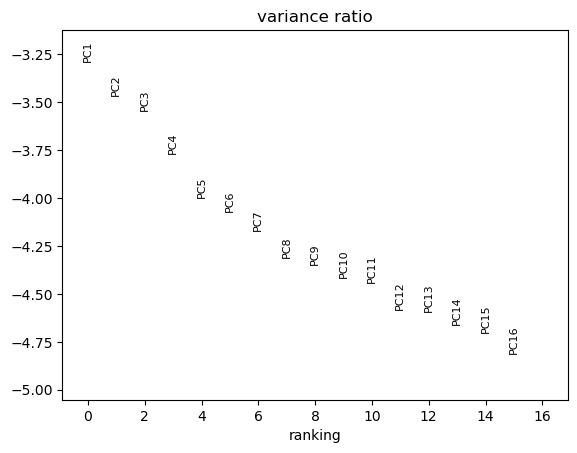

In [53]:
sc.pl.pca_variance_ratio(ST_sample, n_pcs=n_pcs, log=True)

In [54]:
ST_sample.obs.columns

Index(['id', 'mouse', 'sample_id', 'condition', 'cx', 'cy', 'TMA',
       'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mito', 'pct_counts_mito',
       'n_genes', 'Immune_score', 'PTENSKO_score', 'MycCAP_score'],
      dtype='object')

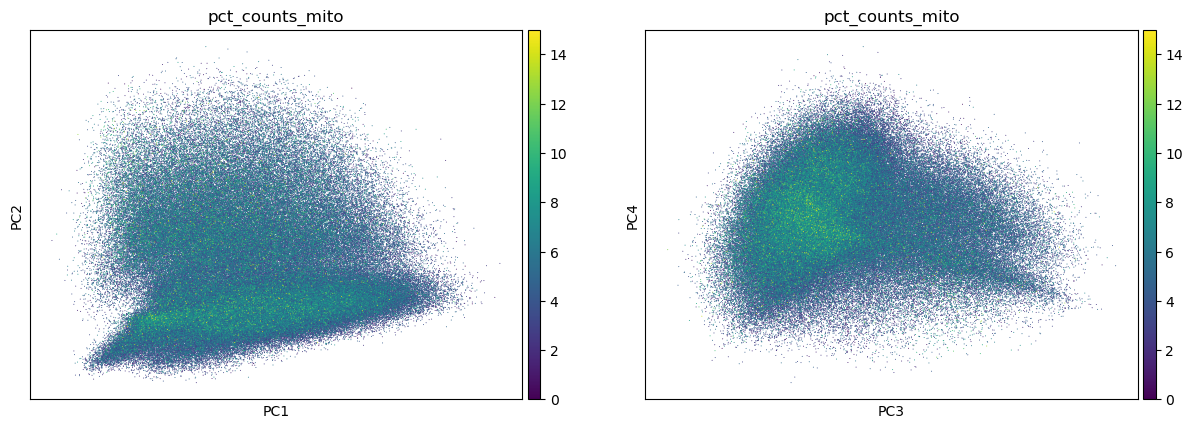

In [55]:
sc.pl.pca(
    ST_sample,
    color=["pct_counts_mito", "pct_counts_mito"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
)

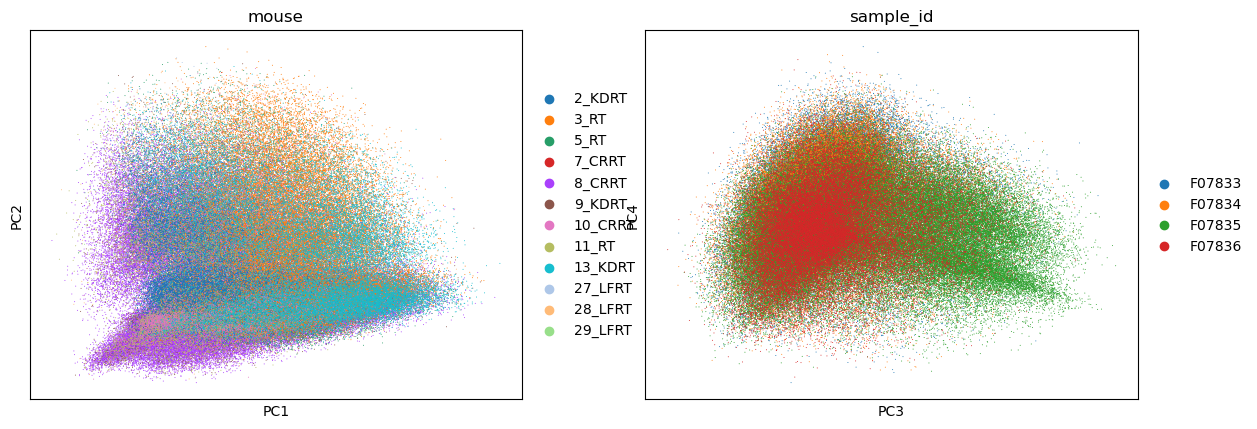

In [56]:
# First the categorical panels (no sorting needed)
sc.pl.pca(
    ST_sample,
    color=["mouse", "sample_id"],
    dimensions=[(0, 1), (2, 3)],
    ncols=2,
    size=2,
    sort_order=False,      # categorical won’t sort anyway
)

In [57]:
# Integration

sce.pp.harmony_integrate(
    ST_sample,
    key='sample_id',
    basis='X_pca',
    adjusted_basis='X_pca_harmony'
)

2025-04-28 18:05:18,538 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-28 18:05:25,134 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-28 18:05:25,516 - harmonypy - INFO - Iteration 1 of 10
2025-04-28 18:06:02,547 - harmonypy - INFO - Iteration 2 of 10
2025-04-28 18:06:41,502 - harmonypy - INFO - Converged after 2 iterations


In [58]:
sc.pp.neighbors(
    ST_sample,
    n_neighbors=30,
    n_pcs=16,
    use_rep='X_pca_harmony',
    transformer=AnnoyTransformer(n_trees=100),
    method="umap",
    knn=True
)

/Users/janzules/anaconda3/envs/spatial_analysis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
resl = 0.15
sc.tl.leiden(
    ST_sample,
    resolution=resl,
    flavor="igraph",
    directed=False,    # Undirected - forces a two way link
    n_iterations=2,
    random_state=1337
)

In [60]:
sc.tl.umap(
    ST_sample,
    init_pos='random',  # instead of 'spectral'
    maxiter=200
)

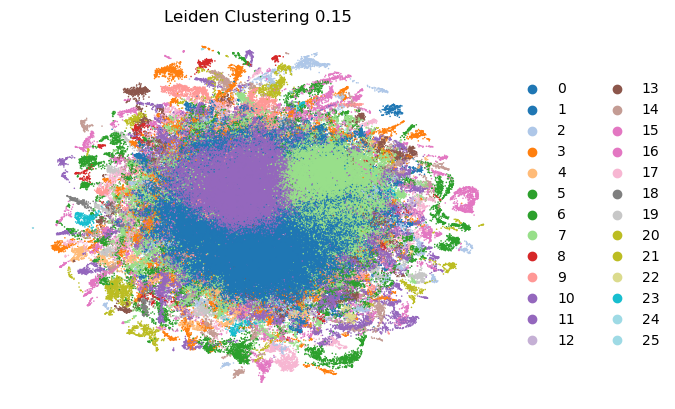

In [61]:
sc.pl.umap(
    ST_sample,
    color='leiden',    # color by your leiden clusters
    palette='tab20',   # nice large color palette
    size=5,            # small dots for large datasets (~1M cells)
    frameon=False,
    title=f'Leiden Clustering {resl}'
)

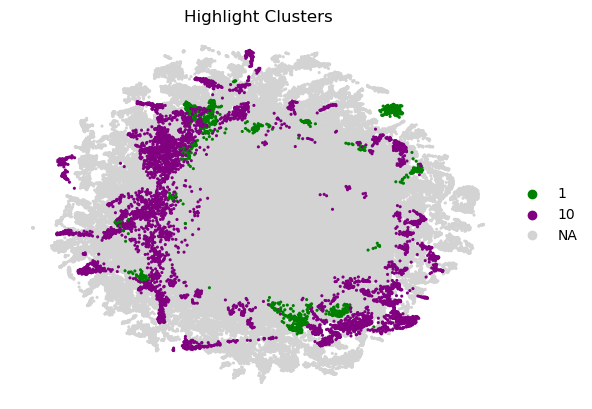

In [62]:
sc.pl.umap(
    ST_sample,
    color='leiden',
    groups=['1','10'],      # only these labels will be colored
    palette=['purple','green'],  # match the order of your groups
    size=20,
    frameon=False,
    title='Highlight Clusters'
)

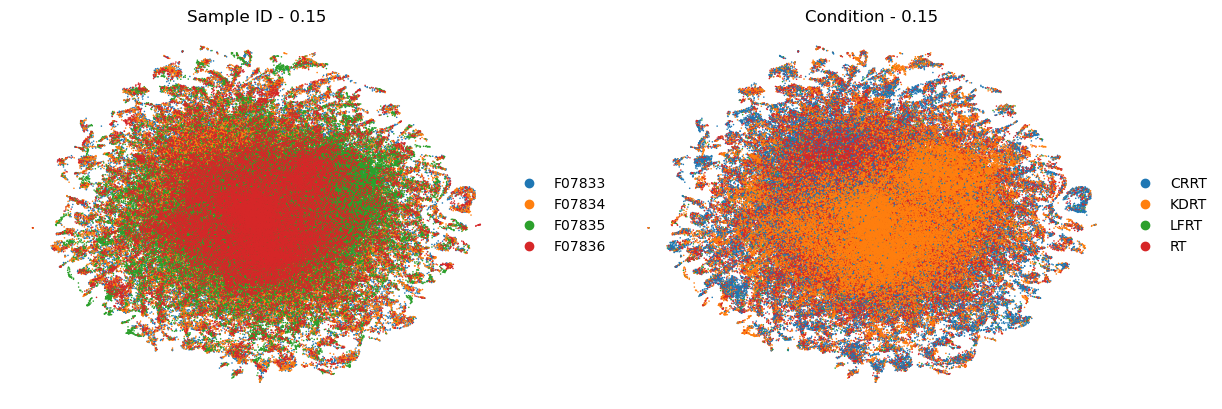

In [63]:
sc.pl.umap(
    ST_sample,
    color=['sample_id', 'condition'],
    ncols=3,            # one panel per key
    size=5,             # adjust dot size for visibility
    frameon=False,
    title=[f'Sample ID - {resl}', f'Condition - {resl}']
)


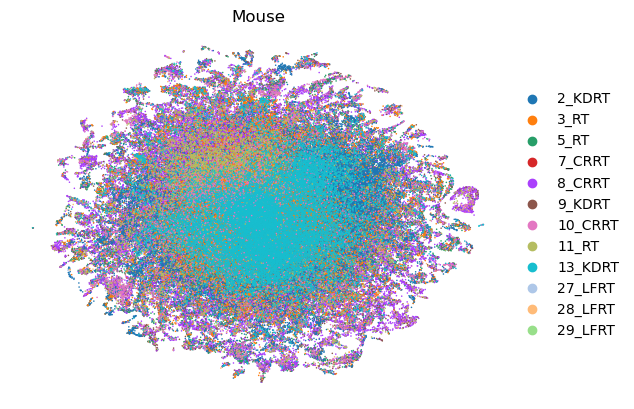

In [64]:
sc.pl.umap(
    ST_sample,
    color=['mouse'],
    ncols=3,            # one panel per key
    size=5,             # adjust dot size for visibility
    frameon=False,
    title=['Mouse']
)


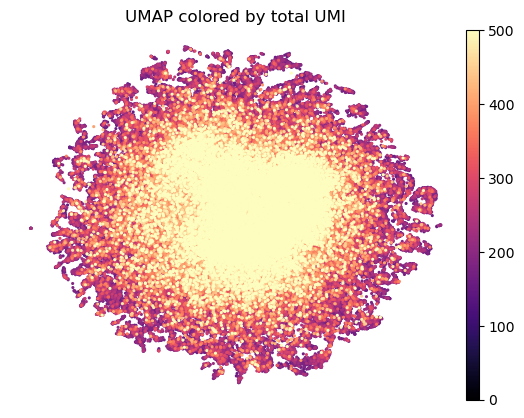

In [65]:
fig = sc.pl.umap(
    ST_sample,
    color='total_counts',
    cmap='magma',
    vmin=0, vmax=500,
    size=20,
    frameon=False,
    title='UMAP colored by total UMI',
    show=False,
    return_fig=True
)


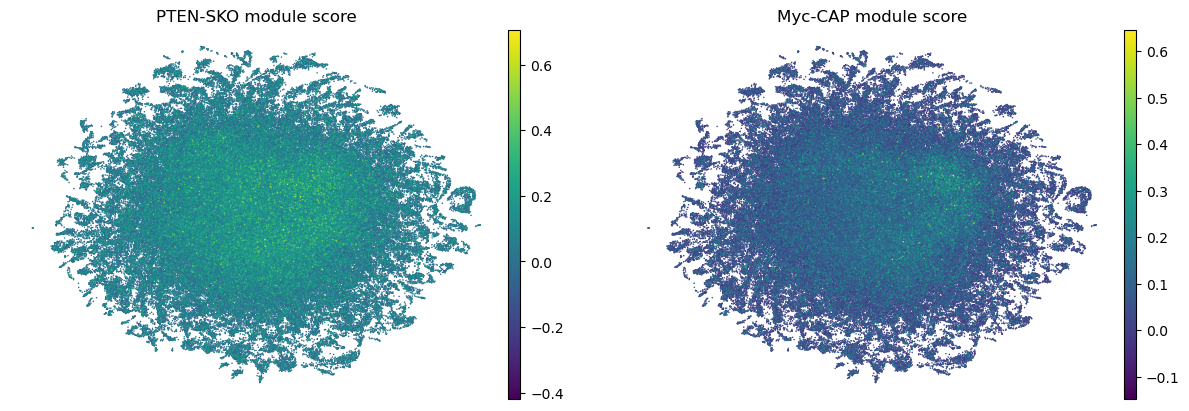

In [66]:
sc.pl.umap(
    ST_sample,
    color=["PTENSKO_score", "MycCAP_score"],
    size=5,
    frameon=False,
    cmap="viridis",
    title=["PTEN-SKO module score", "Myc-CAP module score"]
)

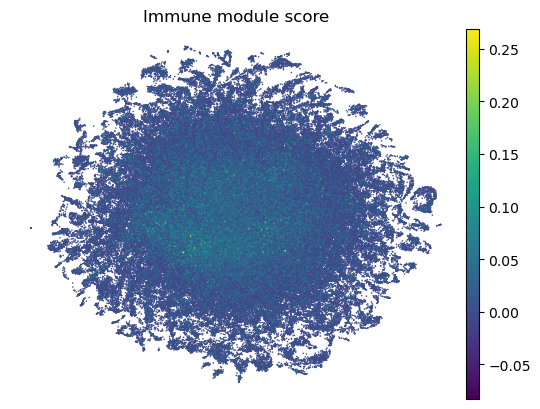

In [67]:
# UMAP overlay - Immune Score

sc.pl.umap(
    ST_sample,
    color="Immune_score",
    size=5,
    frameon=False,
    cmap="viridis",
    title="Immune module score"
)

In [37]:
# fig_out = Path("/Users/janzules/Roselab/Spatial/dietary_project/figures/cell_segmentation_result_analysis/Improving_clustering/")
# fig_out.mkdir(parents=True, exist_ok=True)

# sc.settings.figdir = fig_out
# sc.settings.set_figure_params(dpi=600)

# sc.pl.umap(
#     ST_sample,
#     color="Immune_score",
#     size=5,
#     frameon=False,
#     cmap="viridis",
#     title="Immune module score",
#     save="_immune_score_umap.png",   # produces .../umap_immune_score_umap.png
#     show=False
# )

<Axes: title={'center': 'Immune module score'}, xlabel='UMAP1', ylabel='UMAP2'>

# Resolution Sweep

In [48]:
np.arange(0.2, 0.3, 0.02)

array([0.2 , 0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38])

Saved all figures for resolution 0.14
Saved all figures for resolution 0.15


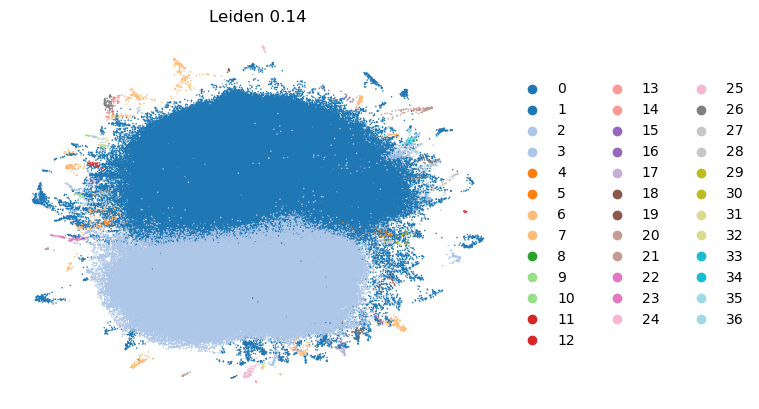

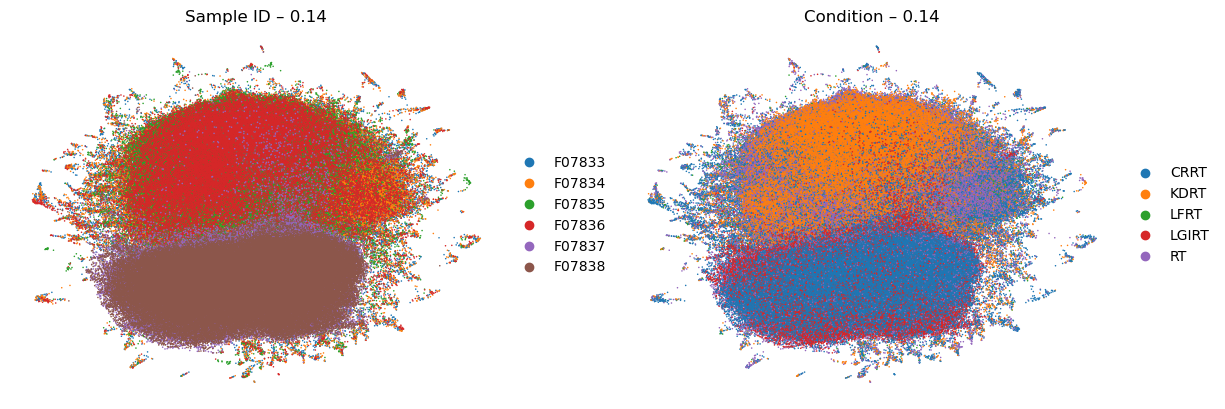

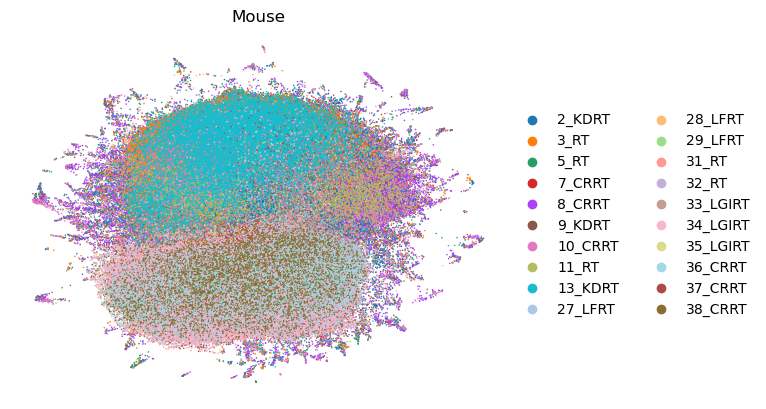

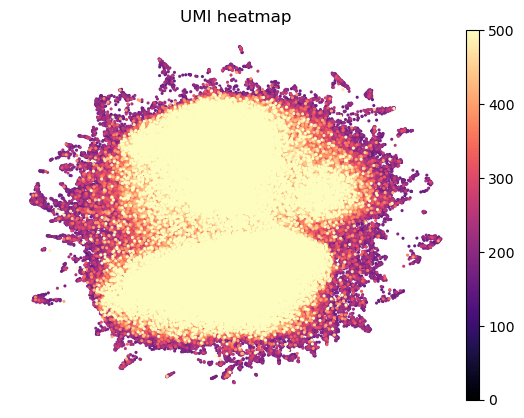

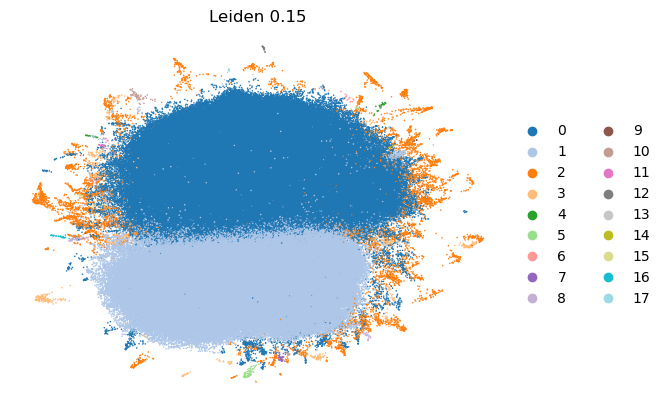

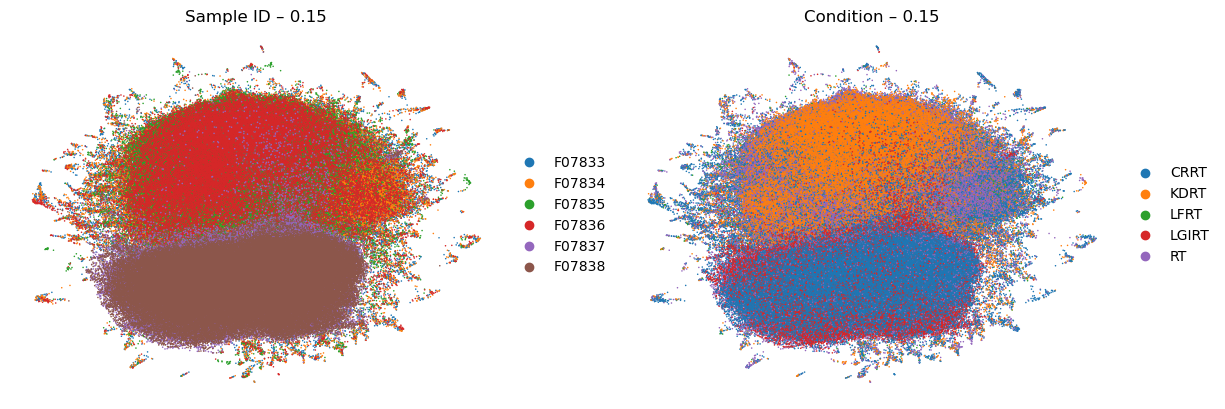

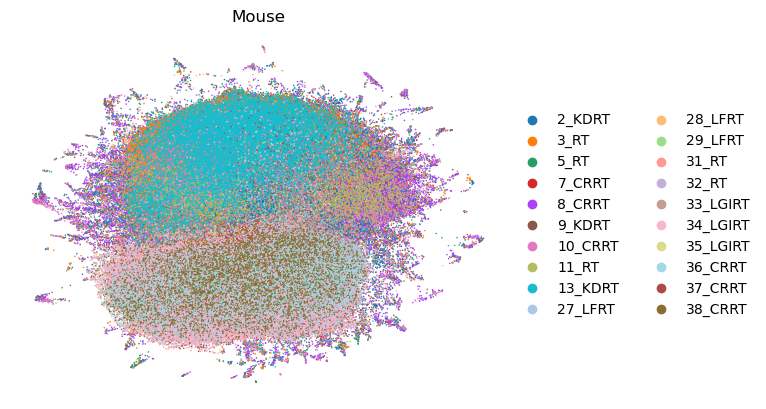

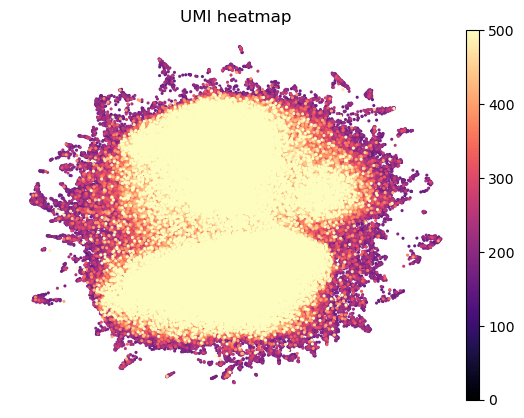

In [58]:
# your existing paths
fig_out     = Path("/Users/janzules/Roselab/Spatial/dietary_project/figures/cell_segmentation_result_analysis/Improving_clustering/")
res_results = fig_out / "resolution_sweep"
res_results.mkdir(parents=True, exist_ok=True)

# define your sweep: start=0.1, stop=1.1 (exclusive), step=0.2 → [0.1,0.3,0.5,0.7,0.9]
resolutions = np.arange(0.14, 0.16, 0.01)

for resl in resolutions:
    key = f"leiden_{resl:.2f}"
    out_dir = res_results / f"{resl:.2f}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # 1) run leiden at this resolution
    sc.tl.leiden(
        ST_sample,
        resolution=resl,
        flavor="igraph",
        directed=False,
        n_iterations=2,
        random_state=1337,
        key_added=key
    )

    # 2) recompute UMAP
    sc.tl.umap(
        ST_sample,
        init_pos='random',
        maxiter=200
    )

    # 3) UMAP: leiden clusters
    fig = sc.pl.umap(
        ST_sample,
        color=key,
        palette='tab20',
        size=5,
        frameon=False,
        title=f'Leiden {resl:.2f}',
        show=False,
        return_fig=True
    )
    fig.savefig(
        out_dir / f"umap_leiden_{resl:.2f}.png",
        dpi=600,
        bbox_inches='tight'
    )

    # 4) UMAP: sample_id + condition
    fig = sc.pl.umap(
        ST_sample,
        color=['sample_id','condition'],
        ncols=2,
        size=5,
        frameon=False,
        title=[f'Sample ID – {resl:.2f}', f'Condition – {resl:.2f}'],
        show=False,
        return_fig=True
    )
    fig.savefig(
        out_dir / f"umap_sample_condition_{resl:.2f}.png",
        dpi=600,
        bbox_inches='tight'
    )

    # 5) UMAP: mouse
    fig = sc.pl.umap(
        ST_sample,
        color='mouse',
        size=5,
        frameon=False,
        title='Mouse',
        show=False,
        return_fig=True
    )
    fig.savefig(
        out_dir / f"umap_mouse_{resl:.2f}.png",
        dpi=600,
        bbox_inches='tight'
    )

    # 6) UMAP: total_counts heatmap
    fig = sc.pl.umap(
        ST_sample,
        color='total_counts',
        cmap='magma',
        vmin=0, vmax=500,
        size=20,
        frameon=False,
        title='UMI heatmap',
        show=False,
        return_fig=True
    )
    fig.savefig(
        out_dir / f"umap_total_counts_{resl:.2f}.png",
        dpi=600,
        bbox_inches='tight'
    )

    print(f"Saved all figures for resolution {resl:.2f}")


# Investigating outlier effect